In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/online-retail/Online Retail.xlsx


In [3]:
df=pd.read_excel("/kaggle/input/online-retail/Online Retail.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# EDA

In [7]:
null_values = df.isnull().sum()
null_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df = df.dropna(subset=["CustomerID"])

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["CustomerID"] = df["CustomerID"].astype(int)

df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

print(f"Cleaned dataset: {df.shape[0]} rows, {df['CustomerID'].nunique()} customers")

Cleaned dataset: 397884 rows, 4338 customers


In [9]:
df['Amount']=df['Quantity']*df['UnitPrice']

In [10]:
df["amount"] = df["Quantity"] * df["UnitPrice"]
customer_sales = df.groupby("CustomerID")["amount"].sum().sort_values(ascending=False)
top_51_sales = customer_sales.iloc[:51].sum()
total_sales = customer_sales.sum()
PercentSales = np.round((top_51_sales / total_sales) * 100, 2)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
monthly_sales = df.resample("ME", on="InvoiceDate")["amount"].sum()
monthly_sales



InvoiceDate
2010-12-31     572713.890
2011-01-31     569445.040
2011-02-28     447137.350
2011-03-31     595500.760
2011-04-30     469200.361
2011-05-31     678594.560
2011-06-30     661213.690
2011-07-31     600091.011
2011-08-31     645343.900
2011-09-30     952838.382
2011-10-31    1039318.790
2011-11-30    1161817.380
2011-12-31     518192.790
Freq: ME, Name: amount, dtype: float64

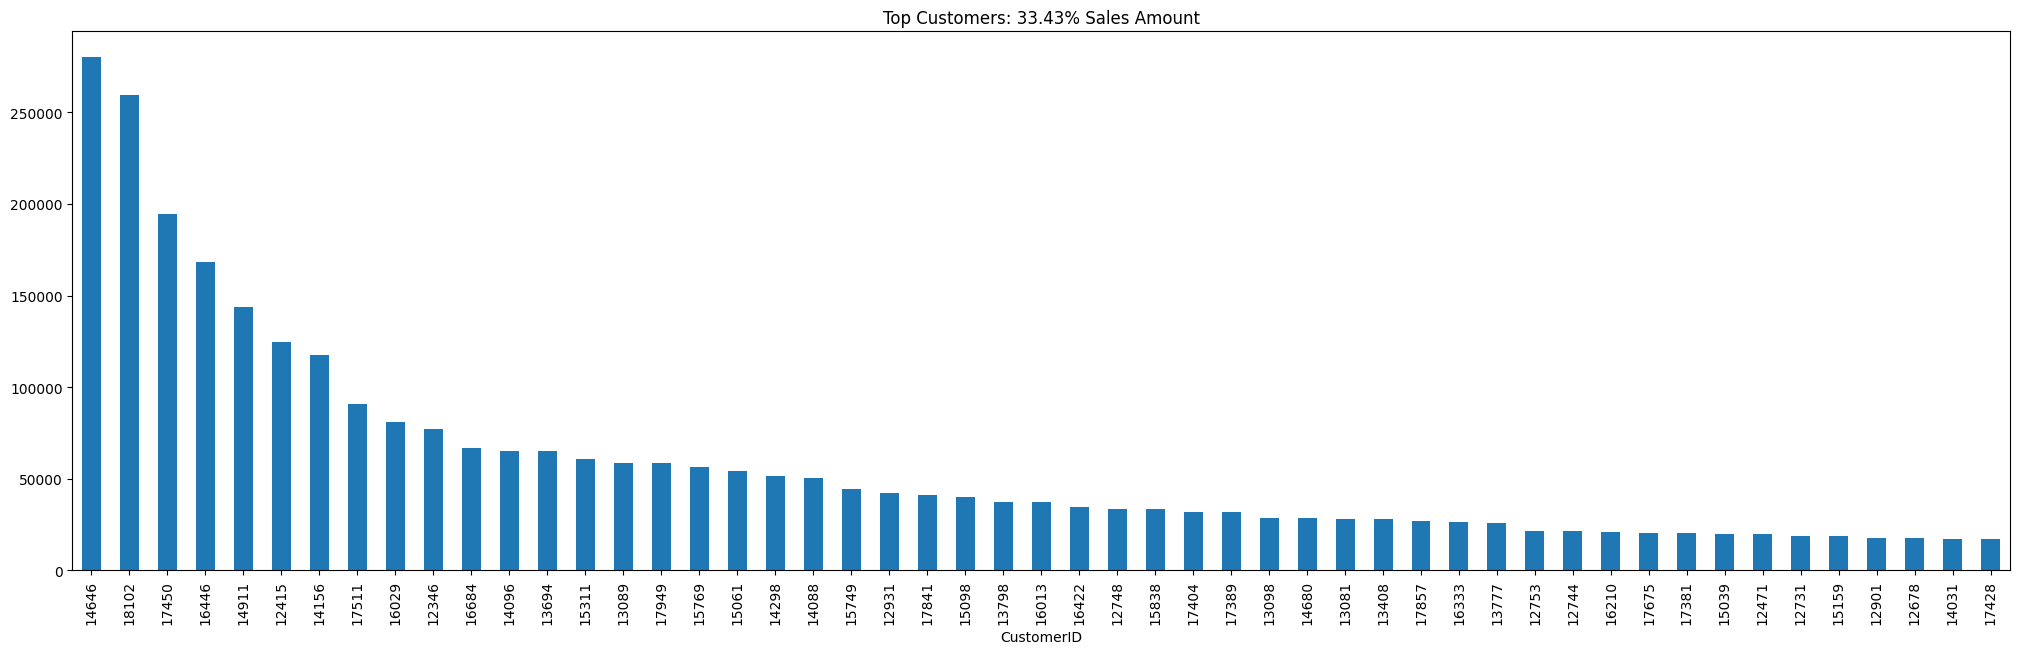

In [11]:
fig, ax = plt.subplots(figsize=(25, 7))
customer_sales.iloc[:51].plot(kind='bar', ax=ax, title=f'Top Customers: {PercentSales:.2f}% Sales Amount')

plt.show()


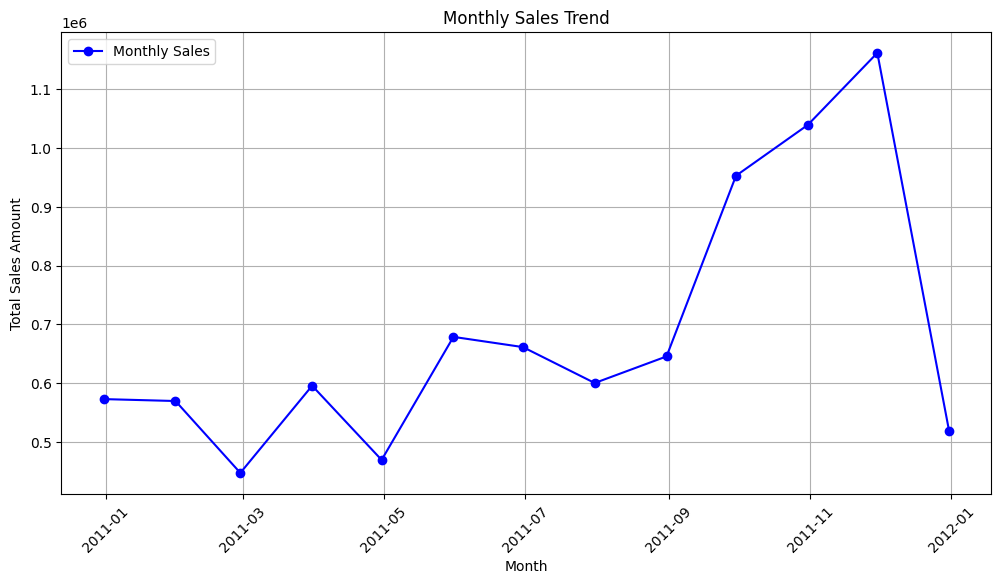

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', color='b', label="Monthly Sales")

plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.title("Monthly Sales Trend")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Most sold items:

In [13]:
grouped=df.groupby(["Description"])

result = grouped.agg({
    "Quantity": "sum", 
    "Amount": "sum"
})

result = result.sort_values("Quantity", ascending=False)
result

,Quantity,Amount
Description,,
"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60
MEDIUM CERAMIC TOP STORAGE JAR,77916,81416.73
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415,13586.25
JUMBO BAG RED RETROSPOT,46181,85220.78
WHITE HANGING HEART T-LIGHT HOLDER,36725,100448.15
...,...,...
BLACK VINT ART DEC CRYSTAL BRACELET,1,6.75
FLOWER SHOP DESIGN MUG,1,1.65
SET 36 COLOURING PENCILS DOILEY,1,1.25


Top 5 customers:

In [14]:

customer_sales = df.groupby("CustomerID").agg({
    "Quantity": "sum"   # total items bought
})

customer_sales = customer_sales.sort_values("Quantity", ascending=False)

print(customer_sales.head())   # show top 5 customers


            Quantity
CustomerID          
14646         196915
16446          80997
14911          80265
12415          77374
12346          74215


No.1 customer:

In [15]:
top_customer = customer_sales.head(1)
print(top_customer)


            Quantity
CustomerID          
14646         196915


Which country has the most customers:

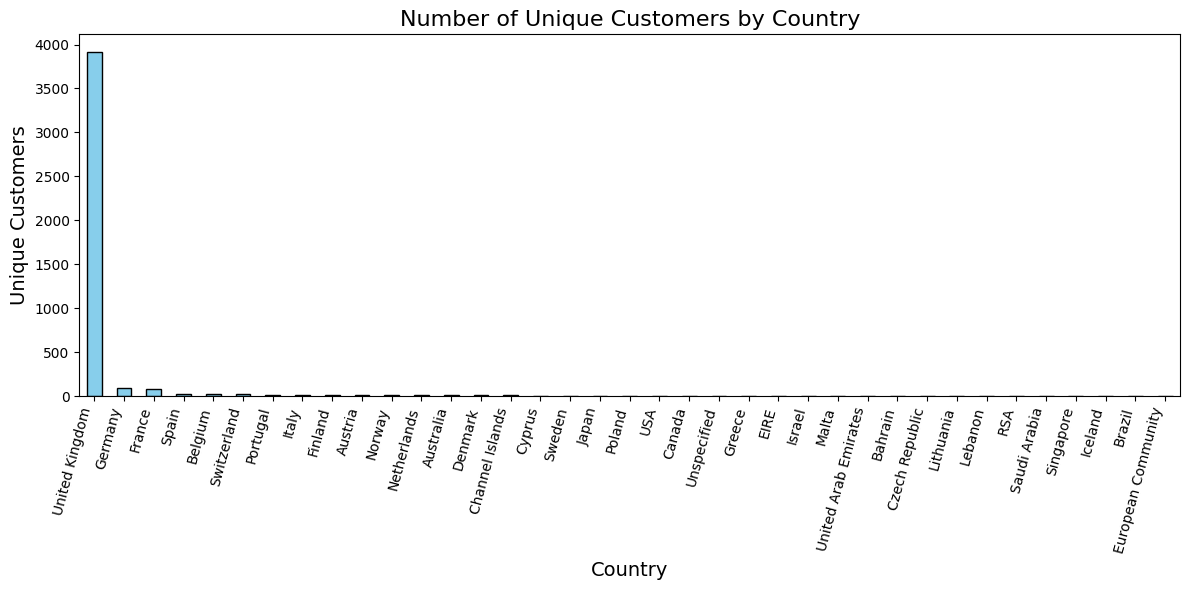

In [16]:

country_customers = df.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
country_customers.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Number of Unique Customers by Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Unique Customers", fontsize=14)
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


In [17]:
# Count unique customers in each country
country_customers = df.groupby("Country")["CustomerID"].nunique()

# Sort to see top countries
country_customers = country_customers.sort_values(ascending=False)

print(country_customers.head())   # top 5 countries


Country
United Kingdom    3920
Germany             94
France              87
Spain               30
Belgium             25
Name: CustomerID, dtype: int64


# *Applying clustering*

In [18]:
import datetime as dt

# Reference point = day after last purchase
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

# Step 1: Create TotalSum column
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# Step 2: Build RFM table
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency (# of unique invoices)
    "TotalSum": "sum"        # Monetary (total spend)
})

# Step 3: Rename columns for clarity
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalSum": "Monetary"
}, inplace=True)

print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [19]:

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])


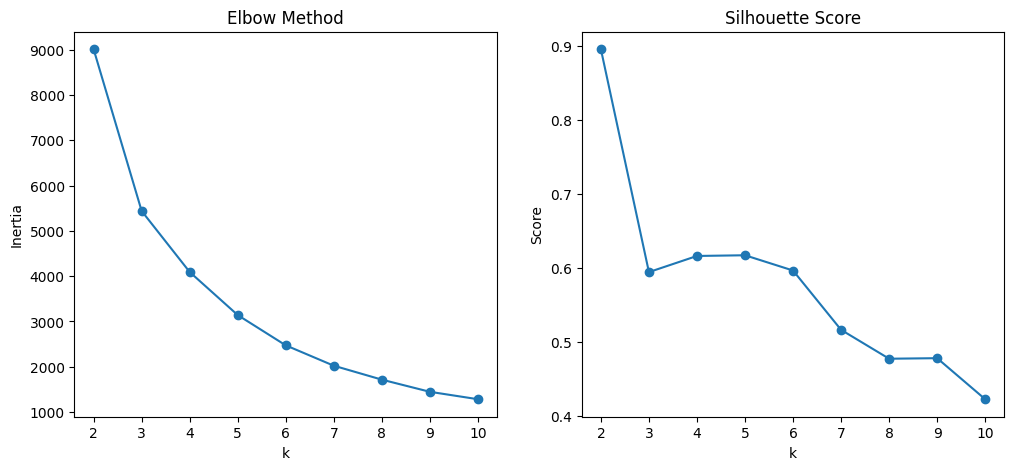

In [20]:
# Try different k's
inertia, silhouette = [], []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, labels))

# Plot elbow & silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K, inertia, marker="o")
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K, silhouette, marker="o")
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score")

plt.show()


In [21]:
best_k = 4  
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Profile clusters
cluster_profile = rfm.groupby("Cluster").mean().round(2)
print(cluster_profile)

# Visualize clusters
sns.pairplot(rfm.reset_index(), hue="Cluster", vars=["Recency","Frequency","Monetary"])
plt.show()


         Recency  Frequency   Monetary
Cluster                               
0         248.56       1.55     478.11
1          15.67      22.05   12453.23
2           7.38      82.54  127338.31
3          43.92       3.66    1350.14


NameError: name 'sns' is not defined

# Market-basket analysis

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Keep only positive quantities
basket = (df[df['Quantity'] > 0]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().fillna(0))

# Convert to bool (saves memory)
basket_sets = basket > 0

# FP-Growth (faster than Apriori)
frequent_itemsets = fpgrowth(basket_sets, min_support=0.01, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print(rules.head())
